# WiD 2025 Datathon - Space Aware

---

## 1 - Preparation

In [48]:
import pandas as pd  
import locale
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as ticker
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [4]:
# DO NOT CHANGE THIS CELL
   
# set the max columns to none to allow view all columns when df.head() is issued.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Default value of display.max_rows is 10 so at max 10 rows will be printed.
# Set it None to display all rows in the dataframe

# This allows us to view all the outputs in a cell.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# This parameter allows bigget columns for long values
# If not set, default value is 100
pd.set_option('display.max_colwidth', 200)

In [5]:
# DO NOT CHANGE THIS CELL

# Number formating
# https://note.nkmk.me/en/python-format-zero-hex/

# set locale to US
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

'en_US.UTF-8'

In [6]:
# DO NOT CHANGE THIS CELL

# Hangling warnings
import warnings                                  # Controls Whether warnings are ignored, displayed or turned into errors
warnings.filterwarnings('ignore')


---

## 2 - Data Source, Definitions and Terminology

Data from:
- [space-track.org](https://www.space-track.org/)

**Apogee**: Point in the orbit where an Earth satellite is farthest from the Earth. Units are kilometers.<br>
**Degree (Argument of Perigee)**: The angle between the ascending node and the orbit's point of closest approach to the Earth (perigee).<br>
**Catalog Number**: Sequential number assigned by the US Space Force as objects are cataloged. Synonyms: Satellite Catalog Number, NORAD_CAT_ID, and OBJECT_NUMBER.<br>
**Celestial Equator**: It is a projection of the terrestrial equator out into space.<br>
**Common Name**: Also known as OBJECT_NAME, this is simply the name associated with the satellite.<br>
**Country**: The nation or group that has responsibility for an object.<br>
**Debris**: Any object with the string 'DEB' or 'COOLANT' or 'SHROUD' or 'WESTFORD NEEDLES' in the SATCAT object common name.<br>
**Decay**: The lessening of the essentricity of the elliptical orbit of an artificial satellite.<br>
**Decay Date**: Date object reentered the Earth's atmosphere in YYYY-MM-DD format.<br>
**Decay Message types**: SATCAT - Historical; Decay Entry - Historical; TIP Message - Prediction; 60day Decay - Prediction.<br>
**Eccentricity**: A constant defining the shape of the orbit (0 = circular; less than 1 = elliptical).<br>
**Element Number**: The ELSET number is a running count of all ELSETs generated by 18 SDS for this object.<br>
**ELSET (Element Set)**: see Two Line Element set.<br>
**Element Set Epoch**: The first two digits ('13') indicate tye year. Add 1900 for years >= 57, and 2000 for all others. The remainder of the field ('236.56031392') is the Julian day of the year.<br>
**Epoch**: The specific time at which the position of a satellite is defined.<br>
**INTLDES - International Designator**: Also known as COSPAR designation or NSSDC ID, this is one format for uniquely identifying an object.<br>
**Latest Data**: Displays the latest ELSET for the object.<br>
**Latest ELSET**: Display the last 5 ELSETs for the object.<br>
**Launch Date**: Date object was launched in YYYY-MM-DD format.<br>
**Launch Number**: A three-letter code representing the sequential identifier of a piece in a launch.<br>
**Mean Anomaly (degrees)**: The angle, measured from perigee, of the satellite location in the orbit referenced to a circular orbit with radius equal to the semi-major axis.<br>
**Mean Equinox**: The direction to the equinox at a particular epoch, with the effect of nutation subctracted.<br>
**Object ID**: The CCSDS's name for International designator.<br>
**Object Number - Catalog Number**: Synonyms: Satellite Catalog Number, NORAD_CAT_ID, Object Number.<br>
**Orbit Inclination (Degrees)**: The angle between the equator and the orbit plane.<br>
**Payload**: Any object not classified in the SATCAT as a rocket body or debris is considered a payload.<br>
**Perigee**: Point in the orbit where an Earth satellite is closest to the Earth. Units are kilometers.<br>
**Period**: The number of minutes an object takes to make one full orbit.<br>
**RCS**: Radar Cross Section.<br>
**Rocket Body**: The propulsion unit(s) used to deploy satellites into orbit. These are cataloged differently from standard debris because they can have mechanisms or fuel on board that can affect the orbital behavior of the rocket body even after long periods of time. Rocket bodies are also constructed to endure high temperatures and stresses associated with launch so they have a greater probability of surviving reentry and require closer attention than most debris. Rocket Bodies are any object which contains the strings 'R/B' or 'AKM' (Apogee Kick Motor) or 'PKM' (Perigee Kick Motor) but not 'DEB' (Debris) in the SATCAT object common name.<br>
**Satellite**: Any object in orbit around the Earth. Used interchangeably with 'resident space object'. However, commonly and mistakenly used to mean payload. Both a piece of debris and the moon are satellites.(SI 534-03) <br>
**Satellite Catalog Number**: Sequential number assigned by the US Space Force as objects are cataloged. Synonyms: Catalog Number, NORAD_CAT_ID, and OBJECT_NUMBER.<br>
**Satellite Catalog (SATCAT)**: A catalog of satellite positional data maintained by 18 SDS.(SI 534-03)<br>
**Space-Track.org**: The website that provides unclassified SSA services and information. Space-Track.org is managed, maintained and administered by S4S.<br>
**Space**: The area above the lowest altitude that permits a vehicle to orbit the Earth without entering the earth's atmosphere. That altitude is approximately 100 kilometers (62 miles).<br>
**Space Surveillance Data**: Data derived from the observation of space and activities occurring in space.<br>
**Space Weather**: The conditions and phenomena in space and specifically in the near-Earth environment that may affect space assets or space operations.<br>
**Vernal Equinox**: The point on the celestial sphere at which the Sun passes from south to north of the celestial equator each year.

**Orbits**:<br>
- GEO: 0.99 <= Mean Motion <= 1.01 and Eccentricity < 0.01
- MEO: 600 minutes <= Period <= 800 minutes and Eccentricity < 0.25
- LEO: Mean Motion > 11.25 and Eccentricity < 0.25
- HEO: Eccentricity > 0.25 

---

## 3 - Functions

**Classifying Orbit**

| Orbit Type | Usual Altitude (km) | Period | Characteristics |
| ---------------- | ------ | ----- | -----|
| LEO - Low Earth Orbit | 160 - 2.000 km | about 90min (88-127min) | Widely used for observation and communication satellites, and constellations like Starlink. High object density. |
| MEO - Medium Earth Orbit | 2.000 - 35.786 km | about 2h to 12h (127-1000min)| Used for GPS and navigation. Lower density than LEO.|
| GEO - Geostationary Orbit | about 35.786 km | about 24h (1436min) | Object appears to be "stationary" over a single point on Earth. Ideal for telecommunications and meteorology.|
| HEO - Highly Elliptical Orbit | Perigee about 1.000km, Apogee till 39.000km) | about 12h (>1000min) | Inclined elliptical orbit. Used for coverage of polar regions or specific communications. |


In [12]:
def fn_classify_orbit(row):
    
    # Verify if required data is not NaN
    if pd.isnull(row['APOGEE']) or pd.isnull(row['PERIGEE']) or pd.isnull(row['PERIOD']):
        return 'Unknown'
    
    # Calculate average altitude
    ave_alt = (row['APOGEE'] + row['PERIGEE']) / 2
    period = row['PERIOD']
    
    # Combined Classification
    if ave_alt < 2000 and 88 <= period <= 127:
        return 'LEO'
    elif 2000 <= ave_alt < 35786 and 127 < period <= 1000:
        return 'MEO'
    elif abs(ave_alt - 35786) < 500 and abs(period - 1436) < 100:
        return 'GEO'
    elif period > 1000:
        return 'HEO'
    else:
        return 'Undefined'

In [30]:
def fn_refined_orbit(row):
    
    # Verify if all required data is not NaN

    if pd.isnull(row['APOGEE']) or pd.isnull(row['PERIGEE']) or pd.isnull(row['PERIOD']):
        return 'Unknown'
    
    # Calculate average altitude
    ave_alt = (row['APOGEE'] + row['PERIGEE']) / 2
    period = row['PERIOD']
    
    # Combined Classification 
    if ave_alt < 2000 and 88 <= period <= 127:
        return 'LEO'
    elif 2000 <= ave_alt < 35786 and 127 < period <= 1000:
        return 'MEO'
    elif abs(ave_alt - 35786) < 500 and abs(period - 1436) < 100:
        return 'GEO'
    elif period > 1000:
        return 'HEO'
    else:
        return 'Undefined'


**Orbit Inclination**

Orbital inclination is the angle between the satellite's orbital plane and Earth's equatorial plane. It is measured in degrees:

- 0° → equatorial orbit (satellite follows the equator)<br>
<br>
- 90° → polar orbit (passes over the poles)<br>
Inclination near 90°<br>
Satellite passes over both poles with each revolution<br>
Ideal for:<br>
1 - Remote sensing<br>
2 - Global mapping<br>
3 - Weather and spy satellites<br>
Allows global coverage over time, as the Earth rotates in the satellite's fixed orbit<br>
<br>
- \> 90° → retrograde orbit (moves opposite to Earth's rotation)<br>
Inclination between 90° and 180°<br>
Satellite moves in the opposite direction to Earth's rotation<br>
More energy-intensive (requires more fuel)<br>
Used in:<br>
1 - Specific scientific missions<br>
2 - Military satellites to avoid interference<br>
3 - Orbital dynamics and resonance studies



Orbit types are categorized by their inclination, which is the angle relative to the equatorial plane. Prograde orbits (0-90°) move in the same direction as Earth's rotation, while retrograde orbits (90-180°) move in the opposite direction. Specific types include Equatorial orbits (0° or 180°), which stay above the equator, and Polar orbits (90°), which pass over both poles. Sun-synchronous orbits are a type of nearly polar orbit useful for consistent imaging. 

**Main Orbits based on inclination**

| Orbit Type | Inclination | Orbit | Details | 
| ---------- | ----------- | ----- | ------- |
| Prograde Orbit | (0° - < 90°) | Equatorial Orbit | Has an inclination of 0°, moving in the same direction as Earth's rotation directly over the equator. |
| Prograde Orbit | (0° - < 90°) | Inclined Orbit | A broad term for any orbit that is not 0° or 180° and is prograde if its inclination is between 0° and 90°. |
| Retrograde Orbit | (90° - 180°) | Equatorial Orbit (180°) | Moves in the opposite direction of Earth's spin, staying above the equator. |
| Retrograde Orbit | (90° - 180°) | Retrograde Orbit | Generally refers to any orbit with an inclination greater than 90° and less than 180°. |
| Specialized Orbits | 90° | Polar Orbit | An orbit with a 90° inclination, meaning the satellite passes over or near both the North and South Poles on each revolution. |
| Specialized Orbits | n/a | Sun-Synchronous Orbit (SSO) | A nearly polar orbit that passes over the same part of the Earth at the same local solar time on every pass, useful for satellites that need consistent lighting conditions. |


Curiosity: The International Space Station (ISS) orbits at about 51.6°, which is a prograde inclined orbit. 

In [13]:
def fn_classify_special_orbit(row):
    inc = row['INCLINATION']
    if pd.isnull(inc):
        return 'Unknown'
    elif 85 <= inc <= 95:
        return 'Polar'
    elif inc > 95:
        return 'Retrograde'
    else:
        return 'Prograde'
    

---

## 4 - Datasets

In [8]:
# Path & File Definitions
datasets_path = '/Users/adrianaweingart/Downloads/WiD - Datathon/Datasets - Space-track/'

ObjectsInOrbit_file = 'ObjectsInOrbit.csv'
ObjectsNoLongerInOrbit_file = 'ObjectsNoLongerInOrbit.csv'

SpaceTrack_file = 'space-track data.xlsx'
Countries_sh = 'Countries'
Objects_sh = 'All Objects'
LaunchSite_sh = 'Launch_Site'


In [9]:
# Importing datasets
ObjectsInOrbit_df = pd.read_csv(datasets_path + ObjectsInOrbit_file)
ObjectsNoLongerInOrbit_df = pd.read_csv(datasets_path + ObjectsNoLongerInOrbit_file)

Objects_df = pd.read_excel(datasets_path + SpaceTrack_file,
                           sheet_name = Objects_sh)
Countries_df = pd.read_excel(datasets_path + SpaceTrack_file,
                             sheet_name = Countries_sh)
LaunchSite_df = pd.read_excel(datasets_path + SpaceTrack_file,
                              sheet_name = LaunchSite_sh)


In [10]:
%%script true
# Consolidating datasets in a unique df
df = pd.concat([ObjectsNoLongerInOrbit_df, 
                ObjectsInOrbit_df], 
               ignore_index = True)


In [11]:
df = Objects_df.copy()

---

## 5 - Feature Engineering

In [38]:
%%script true
# LAUNCH_YEAR
df['LAUNCH_YEAR'] = df['LAUNCH'].str[:4]
df['LAUNCH_YEAR'] = df['LAUNCH_YEAR'].astype(int)

# DECAY_YEAR
df['DECAY_YEAR'] = df['DECAY'].str[:4]
df['DECAY_YEAR'] = df['DECAY_YEAR'].astype(int)


In [26]:
# DECAY_YEAR
df['DECAY_YEAR'] = df['DECAY'].dt.year


In [39]:
# Orbit Classification (for Objects in Orbit)
df['ORBIT_TYPE'] = df.apply(fn_classify_orbit, 
                            axis = 1)

df['ORBIT_TYPE_Refined'] = df.apply(fn_refined_orbit, 
                                    axis = 1)


In [152]:
# Defining OBJECT_TYPE category order
OBJ_Order = ['PAYLOAD', 'DEBRIS', 'ROCKET BODY', 'UNKNOWN']

# Crie um tipo categórico ordenado
obj_type_order = CategoricalDtype(categories = OBJ_Order, 
                                  ordered = True)

# Applying to dataframe
df['OBJECT_TYPE'] = df['OBJECT_TYPE'].astype(obj_type_order)


In [229]:
# Defina a ordem desejada
Orbit_Order = ['LEO', 'MEO', 'GEO', 'HEO', 'Unknown', 'Undefined']

# Crie o tipo categórico ordenado
orbit_type_order = CategoricalDtype(categories = Orbit_Order, 
                                    ordered = True)

# Aplique ao DataFrame
df['ORBIT_TYPE'] = df['ORBIT_TYPE'].astype(orbit_type_order)


In [40]:
# Orbit Direction (for Objects in Orbit)
df['ORBIT_DIRECTION'] = df.apply(fn_classify_special_orbit, 
                                 axis = 1)


In [41]:
# Rename column COUNTRY to COUNTRY_ACRONYM
df.rename(columns = {'COUNTRY': 'COUNTRY_ACRONYM'}, 
          inplace = True)

# Include Full Country name (as column COUNTRY) based on Countries_df
countries_df_reduzido = Countries_df[['SIGLA', 'COUNTRY']]

df = df.merge(countries_df_reduzido, 
              left_on = 'COUNTRY_ACRONYM', 
              right_on = 'SIGLA', 
              how = 'left')

df.drop(columns = ['SIGLA'], 
        inplace = True)


By crossing `ORBIT_TYPE` (based in altitude and period) and `ORBIT_DIRECTION`, based in inclination, it is possible to find patterns such as:<br>

- Polar LEO satellites (*): very common in Earth observation. <br>
- Prograde GEO satellites (*): typical for telecommunications. <br>
- Retrograde HEO satellites (*): rare adn used in special missions. 

In [61]:
# Cross Table ('ORBIT_TYPE' & 'ORBIT_DIRECTION') to find patterns
cross_table = pd.crosstab(df['ORBIT_TYPE'], 
                          df['ORBIT_DIRECTION'])
cross_table

ORBIT_DIRECTION  Polar  Prograde  Unknown  retrograde
ORBIT_TYPE                                           
GEO                  0      1519        0           0
HEO                  7       497        0           5
LEO               3009     33423        0       14495
MEO                144      3716        0          47
Undefined          145      5952        0        1508
Unknown              0         0      993           0

In [322]:
# Create a dataset of active objects
df_active = df[df['DECAY'].isnull()].copy()

In [315]:
# Create a dataset of inactive (DECAY) objects
df_inactive = df[df['DECAY'].notnull()].copy()

In [316]:
df['ACTIVE'] = df['DECAY'].apply(lambda x: 0 if pd.notnull(x) else 1)
df['ACTIVE_LABEL'] = df['ACTIVE'].map({0: 'INACTIVE', 1: 'ACTIVE'})

---

## 6 - Data Collection

In [278]:
# Number of Active Objects in Orbit
df[df['ACTIVE'] == 1]['SATNAME'].count()

31425

In [279]:
# Number of Active Objects that are Payloads
df[(df['ACTIVE'] == 1) & (df['OBJECT_TYPE'] == 'PAYLOAD')]['SATNAME'].count()

15572

In [290]:
print('Number of DEBRIS in LEO')
print(df_active[(df_active['OBJECT_TYPE'] == 'DEBRIS') & (df_active['ORBIT_TYPE'] == 'LEO')]['SATNAME'].count())

print('Number of objects in LEO')
print(df_active[(df_active['ORBIT_TYPE'] == 'LEO')]['SATNAME'].count())

print('Percentage of DEBRIS in LEO')
print((df_active[(df_active['OBJECT_TYPE'] == 'DEBRIS') & (df_active['ORBIT_TYPE'] == 'LEO')]['SATNAME'].count()) / (df_active[(df_active['ORBIT_TYPE'] == 'LEO')]['SATNAME'].count())
     )

Number of DEBRIS in LEO
10415
Number of objects in LEO
25276
Percentage of DEBRIS in LEO
0.4120509574299731


In [304]:
print('Number of ROCKET BODY in LEO')
print(df_active[(df_active['OBJECT_TYPE'] == 'ROCKET BODY') & (df_active['ORBIT_TYPE'] == 'LEO')]['SATNAME'].count())

print('Number of objects in LEO')
print(df_active[(df_active['ORBIT_TYPE'] == 'LEO')]['SATNAME'].count())

print('Percentage of DEBRIS in LEO')
print((df_active[(df_active['OBJECT_TYPE'] == 'ROCKET BODY') & (df_active['ORBIT_TYPE'] == 'LEO')]['SATNAME'].count()) / (df_active[(df_active['ORBIT_TYPE'] == 'LEO')]['SATNAME'].count())
     )

Number of ROCKET BODY in LEO
983
Number of objects in LEO
25276
Percentage of DEBRIS in LEO
0.03889064725431239


In [305]:
( 10415 + 960 ) / 25276

0.45003165057762307

In [296]:
print('Number of DEBRIS in MEO')
print(df_active[(df_active['OBJECT_TYPE'] == 'DEBRIS') & (df_active['ORBIT_TYPE'] == 'MEO')]['SATNAME'].count())

print('Number of objects in MEO')
print(df_active[(df_active['ORBIT_TYPE'] == 'MEO')]['SATNAME'].count())

print('Percentage of DEBRIS in MEO')
print((df_active[(df_active['OBJECT_TYPE'] == 'DEBRIS') & (df_active['ORBIT_TYPE'] == 'MEO')]['SATNAME'].count()) / (df_active[(df_active['ORBIT_TYPE'] == 'MEO')]['SATNAME'].count()))


Number of DEBRIS in MEO
2086
Number of objects in MEO
3515
Percentage of DEBRIS in MEO
0.5934566145092461


In [301]:
print('Number of ROCKET BODY in MEO')
print(df_active[(df_active['OBJECT_TYPE'] == 'ROCKET BODY') & (df_active['ORBIT_TYPE'] == 'MEO')]['SATNAME'].count())

print('Number of objects in MEO')
print(df_active[(df_active['ORBIT_TYPE'] == 'MEO')]['SATNAME'].count())

print('Percentage of ROCKET BODY in MEO')
print((df_active[(df_active['OBJECT_TYPE'] == 'ROCKET BODY') & (df_active['ORBIT_TYPE'] == 'MEO')]['SATNAME'].count()) / (df_active[(df_active['ORBIT_TYPE'] == 'MEO')]['SATNAME'].count()))


Number of ROCKET BODY in MEO
860
Number of objects in MEO
3515
Percentage of ROCKET BODY in MEO
0.24466571834992887


In [303]:
print('Number of PAYLOAD in MEO')
print(df_active[(df_active['OBJECT_TYPE'] == 'PAYLOAD') & (df_active['ORBIT_TYPE'] == 'MEO')]['SATNAME'].count())

print('Number of objects in MEO')
print(df_active[(df_active['ORBIT_TYPE'] == 'MEO')]['SATNAME'].count())

print('Percentage of DEBRIS in MEO')
print((df_active[(df_active['OBJECT_TYPE'] == 'PAYLOAD') & (df_active['ORBIT_TYPE'] == 'MEO')]['SATNAME'].count()) / (df_active[(df_active['ORBIT_TYPE'] == 'MEO')]['SATNAME'].count()))


Number of PAYLOAD in MEO
564
Number of objects in MEO
3515
Percentage of DEBRIS in MEO
0.1604551920341394


## 7 - Data Visualization

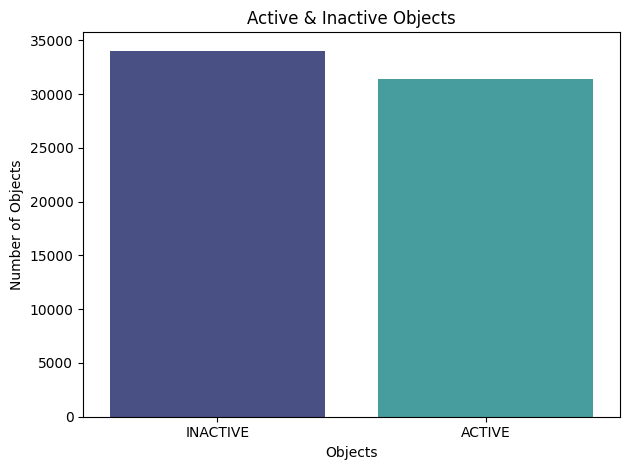

In [272]:
# Object Distribution per Active and Decay

# Create a Seaborn color palette
seq_palette = sns.color_palette('mako', 2)

sns.countplot(data = df, 
              x = 'ACTIVE_LABEL', 
              palette = seq_palette)

plt.title('Active & Inactive Objects')
plt.xlabel('Objects')
plt.ylabel('Number of Objects')

# Adding count to the bars
for label in ax.containers:
    ax.bar_label(label)

plt.tight_layout()

plt.show();

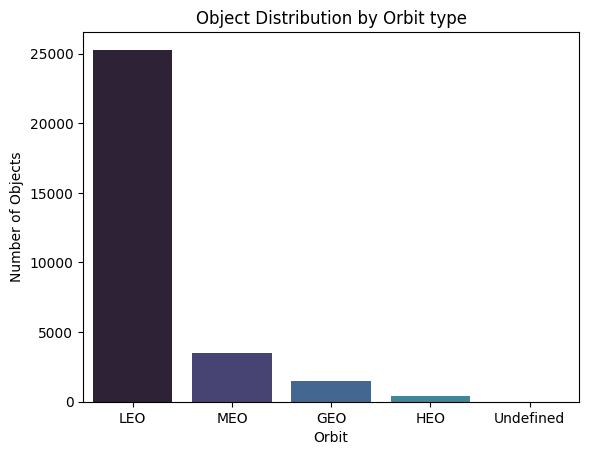

In [282]:
# Object Distribution per Orbit Type

# Create a Seaborn color palette
seq_palette = sns.color_palette('mako', 6)

sns.countplot(data = df_active, 
              x = 'ORBIT_TYPE', 
              order = ['LEO', 'MEO', 'GEO', 'HEO', 'Undefined'],
              palette = seq_palette)
plt.title('Object Distribution by Orbit type')
plt.xlabel('Orbit')
plt.ylabel('Number of Objects')
plt.show();


In [51]:
df['COUNTRY'].value_counts().index[:20]

Index(['UNITED STATES OF AMERICA ', 'COMMONWEALTH OF INDEPENDENT STATES ',
       'PEOPLES REPUBLIC OF CHINA ', 'FRANCE ', 'JAPAN ', 'INDIA ',
       'UNITED KINGDOM ', 'TO BE DETERMINED/UNKNOWN ',
       'EUROPEAN SPACE AGENCY ',
       'INTERNATIONAL TELECOMMUNICATIONS SATELLITE ORGANIZATION (INTELSAT)',
       'GERMANY ', 'ITALY ', 'INTERNATIONAL SPACE STATION ', 'CANADA ',
       'ORBITAL TELECOMMUNICATIONS SATELLITE (GLOBALSAT)',
       'PEOPLES REPUBLIC OF CHINA/BRAZIL ', 'GLOBALSTAR ', 'SPAIN ',
       'SOCIÉTÉ EUROPÉENNE DES SATELLITES ', 'ARGENTINA '],
      dtype='object', name='COUNTRY')

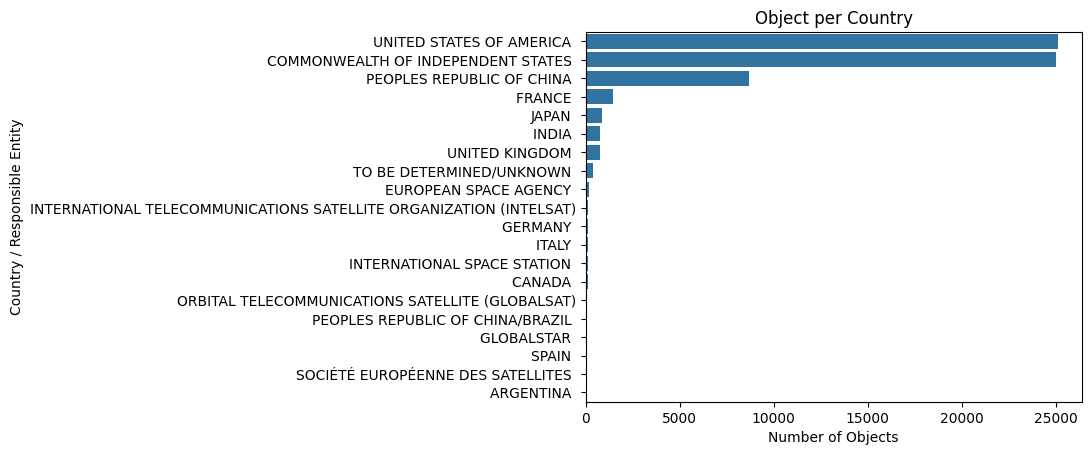

In [55]:
# Objects per Country

sns.countplot(data = df,
              y = 'COUNTRY',
              order = df['COUNTRY'].value_counts().index[:20])

plt.title('Object per Country')
plt.xlabel('Number of Objects')
plt.ylabel('Country / Responsible Entity')
plt.show();

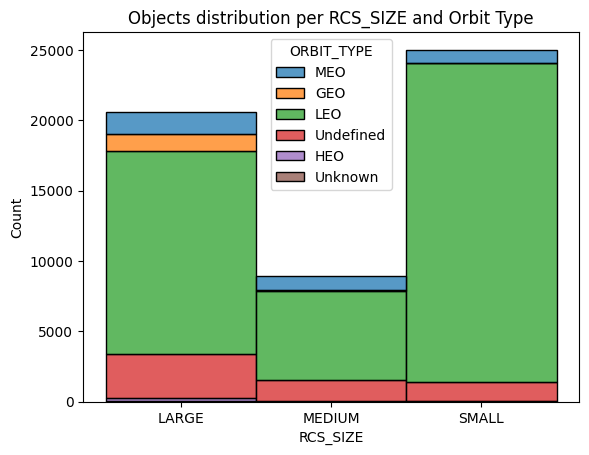

In [58]:
# Objects distribution per RCS_SIZE and Orbit Type

sns.histplot(data = df, 
             x = 'RCS_SIZE', 
             hue = 'ORBIT_TYPE', 
             multiple = 'stack')

plt.title('Objects distribution per RCS_SIZE and Orbit Type')
plt.show();

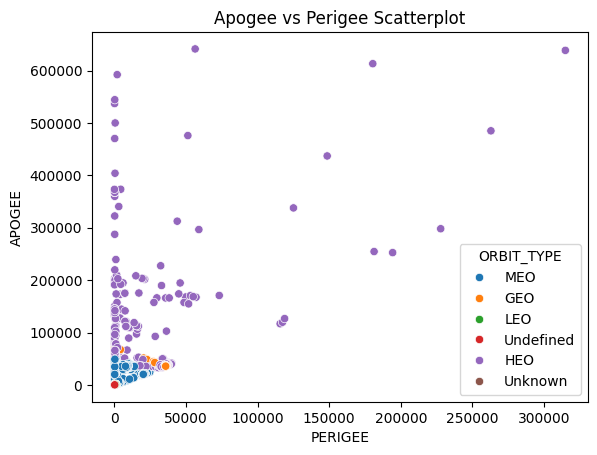

In [60]:
# Apogee vs Perigee Scatterplot

sns.scatterplot(data = df, 
                x = 'PERIGEE', 
                y = 'APOGEE', 
                hue = 'ORBIT_TYPE')

plt.title('Apogee vs Perigee Scatterplot')
plt.show();

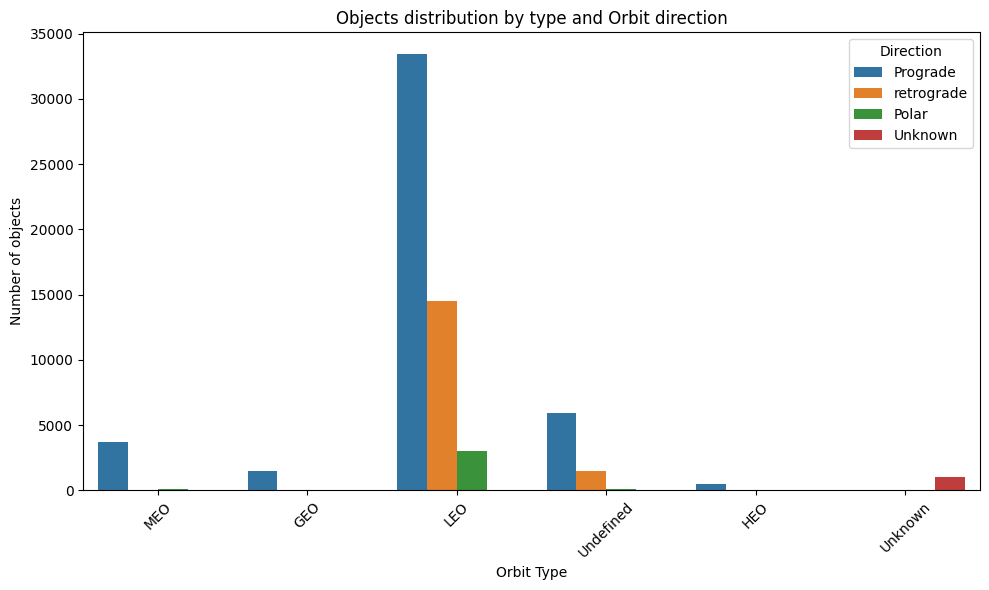

In [62]:
plt.figure(figsize = (10, 6))
sns.countplot(data = df, 
              x = 'ORBIT_TYPE', 
              hue = 'ORBIT_DIRECTION')
plt.title('Objects distribution by type and Orbit direction')
plt.xlabel('Orbit Type')
plt.ylabel('Number of objects')
plt.legend(title = 'Direction')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show();

In [113]:
# Object Types in Orbit
df['OBJECT_TYPE'].value_counts()

OBJECT_TYPE
DEBRIS         35726
PAYLOAD        22018
ROCKET BODY     6746
UNKNOWN          970
Name: count, dtype: int64

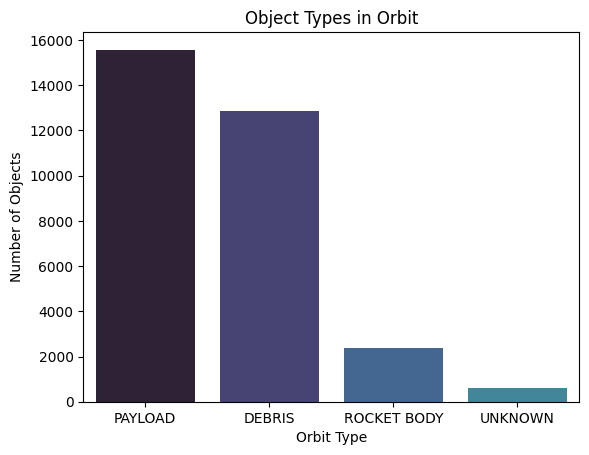

In [281]:
# Object Types in Orbit

# Create a Seaborn color palette
seq_palette = sns.color_palette('mako', 6)

df['OBJECT_TYPE'].value_counts()

sns.countplot(data = df_active, 
              x = 'OBJECT_TYPE',
              hue = 'OBJECT_TYPE',
              palette = seq_palette)
#              x = 'ORBIT_TYPE', 
#              order = ['LEO', 'MEO', 'GEO', 'HEO', 'Undefined'])
plt.title('Object Types in Orbit')
plt.xlabel('Orbit Type')
plt.ylabel('Number of Objects')
plt.show();


In [164]:
%%script true

# Objects types distribution in LEO Orbit

# Create a Seaborn color palette
seq_palette = sns.color_palette('mako', 6)

# Maping category / color
palette_dict = dict(zip(ordem_objetos, seq_palette))

plt.figure(figsize = (10, 2))

ax = sns.histplot(data = (df[df['ORBIT_TYPE'] == 'LEO']), 
                  x = 'OBJECT_TYPE', 
                  hue = 'OBJECT_TYPE', 
                  palette = seq_palette)             
#             multiple = 'stack')

ax.get_legend().remove()

plt.title('Objects types distribution in LEO Orbit')
plt.show();

In [165]:
%%script true
# Objects types distribution in MEO Orbit

# Create a Seaborn color palette
seq_palette = sns.color_palette('mako', 6)

plt.figure(figsize = (10, 2))

ax = sns.histplot(data = (df[df['ORBIT_TYPE'] == 'MEO']), 
                  x = 'OBJECT_TYPE', 
                  hue = 'OBJECT_TYPE', 
                  palette = seq_palette)             
#             multiple = 'stack')

ax.get_legend().remove()

plt.title('Objects types distribution in MEO Orbit')
plt.show();

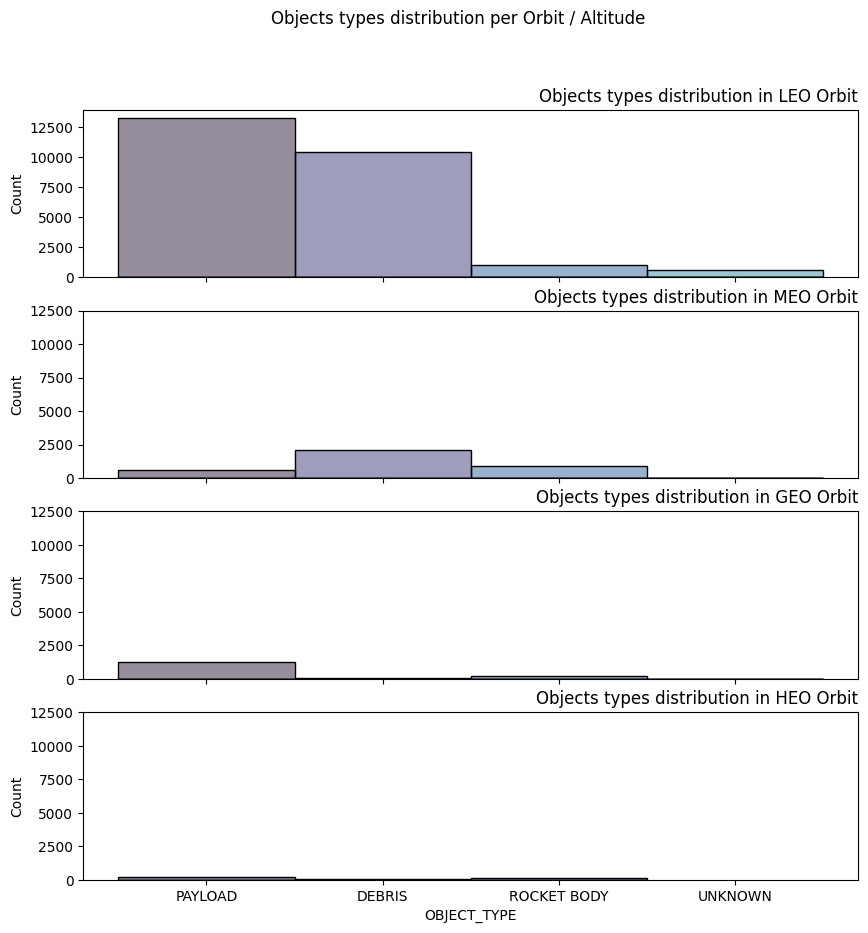

In [284]:
# Create a Seaborn color palette
seq_palette = sns.color_palette('mako', 6)

# Mapping color / category
palette_dict = dict(zip(OBJ_Order, seq_palette))

fig, axes = plt.subplots(nrows = 4, 
                         ncols = 1, 
                         sharex = True, 
                         figsize = (10, 10))

fig.suptitle('Objects types distribution per Orbit / Altitude')


# Plot LEO
sns.histplot(ax = axes[0], 
             data = (df_active[df_active['ORBIT_TYPE'] == 'LEO']), 
             x = 'OBJECT_TYPE', 
             hue = 'OBJECT_TYPE',
             hue_order = OBJ_Order,
             kde = True,
             palette = seq_palette)
axes[0].set_title('Objects types distribution in LEO Orbit', 
                  loc = 'right')
#axes[0].set_ylim(0, 3000)
axes[0].legend_.remove()

# Plot MEO
sns.histplot(ax = axes[1], 
             data = (df_active[df_active['ORBIT_TYPE'] == 'MEO']), 
             x = 'OBJECT_TYPE', 
             hue = 'OBJECT_TYPE', 
             hue_order = OBJ_Order,             
             kde = True,
             palette = seq_palette)
axes[1].set_title('Objects types distribution in MEO Orbit', 
                  loc = 'right')
axes[1].set_ylim(0, 12500)
axes[1].legend_.remove()

# Plot GEO
sns.histplot(ax = axes[2], 
             data = (df_active[df_active['ORBIT_TYPE'] == 'GEO']), 
             x = 'OBJECT_TYPE', 
             hue = 'OBJECT_TYPE',
             hue_order = OBJ_Order,             
             kde = True,
             palette = seq_palette)
axes[2].set_title('Objects types distribution in GEO Orbit', 
                  loc = 'right')
axes[2].set_ylim(0, 12500)
axes[2].legend_.remove()

# Plot HEO
sns.histplot(ax = axes[3], 
             data = (df_active[df_active['ORBIT_TYPE'] == 'HEO']), 
             x = 'OBJECT_TYPE', 
             hue = 'OBJECT_TYPE', 
             hue_order = OBJ_Order,             
             kde = True,
             palette = seq_palette)
axes[3].set_title('Objects types distribution in HEO Orbit', 
                  loc = 'right')
axes[3].set_ylim(0, 12500)
axes[3].legend_.remove()


plt.show();

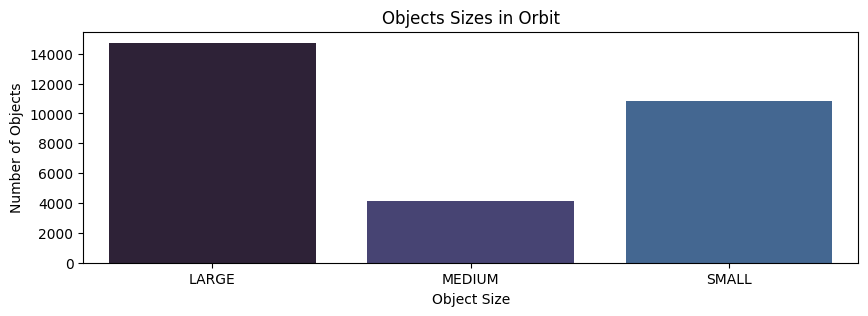

In [306]:
# Object Size in Orbit

# Create a Seaborn color palette
seq_palette = sns.color_palette('mako', 6)

plt.figure(figsize = (10, 3))

ax = sns.countplot(data = df_active, 
              x = 'RCS_SIZE',
              hue = 'RCS_SIZE',
              palette = seq_palette)
plt.title('Objects Sizes in Orbit')
plt.xlabel('Object Size')
plt.ylabel('Number of Objects')
ax.get_legend().remove()
plt.show();


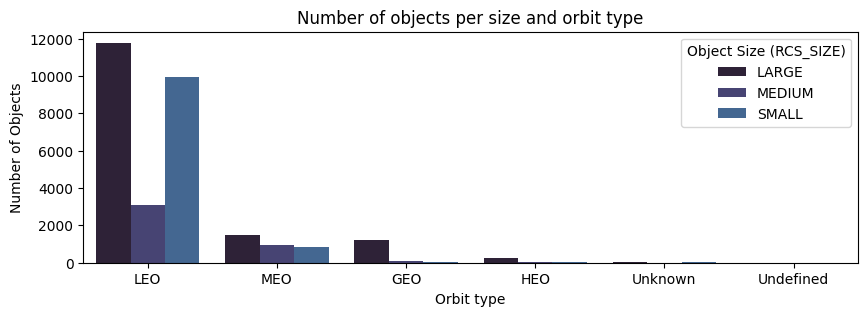

In [307]:
# Create a Seaborn color palette - generate 10 colors and get the last 6
full_palette = sns.color_palette('light:#007acc', 3)
#seq_palette = full_palette[-3:]

plt.figure(figsize = (10, 3))

sns.countplot(data = df_active, 
              x = 'ORBIT_TYPE', 
              hue = 'RCS_SIZE',
              order = Orbit_Order,
              palette = seq_palette)          

plt.title('Number of objects per size and orbit type')
plt.xlabel('Orbit type')
plt.ylabel('Number of Objects')
plt.legend(title = 'Object Size (RCS_SIZE)')
 
plt.show();

---

## 8 - Analysis

### 8.1 - Cluster - K-Means

In [75]:
# Preparing the data

# Selecting relevant columns
features = ['PERIOD', 
            'INCLINATION', 
            'APOGEE', 
            'PERIGEE', 
            'RCS_SIZE']

# Copy dataframe and remove NaN
df_cluster = df[features].dropna().copy()

# Convert RCS_SIZE for numeric values
rcs_map = {'SMALL': 1, 
           'MEDIUM': 2, 
           'LARGE': 3}
df_cluster['RCS_SIZE'] = df_cluster['RCS_SIZE'].map(rcs_map)

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

In [73]:
# Testing values for k (number of clusters)

scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, 
                    random_state = 42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores.append((k, score))

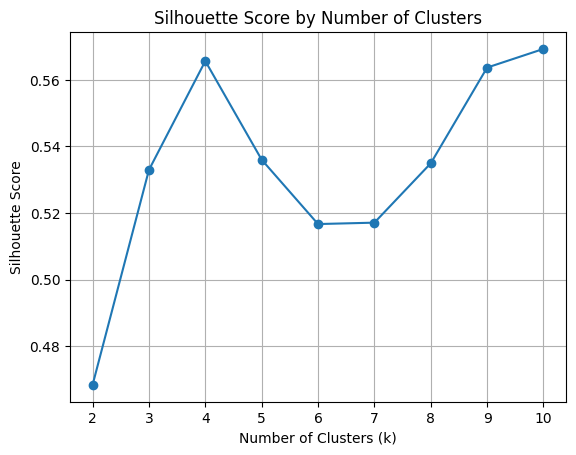

In [74]:
# Visualizing the scores
ks, s_scores = zip(*scores)
plt.plot(ks, s_scores, marker = 'o')
plt.title('Silhouette Score by Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show();

In [76]:
# Apply K-Means - k = 4

# 4 clusters
kmeans = KMeans(n_clusters = 4, 
                 random_state = 42)
df_cluster['CLUSTER'] = kmeans4.fit_predict(X_scaled)


In [77]:
# Add clusters to original dataframe
df.loc[df_cluster.index, 'CLUSTER'] = df_cluster['CLUSTER']


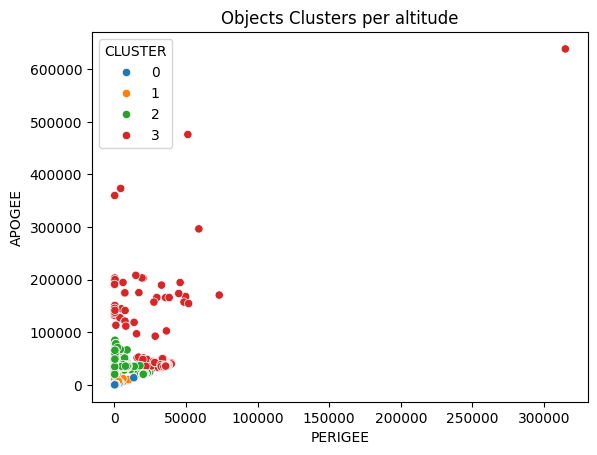

In [78]:
# Visualizing Clusters

# Visualize cluster distribution
sns.scatterplot(data = df_cluster, 
                x = 'PERIGEE', 
                y = 'APOGEE', 
                hue = 'CLUSTER', 
                palette = 'tab10')
plt.title('Objects Clusters per altitude')
plt.show();

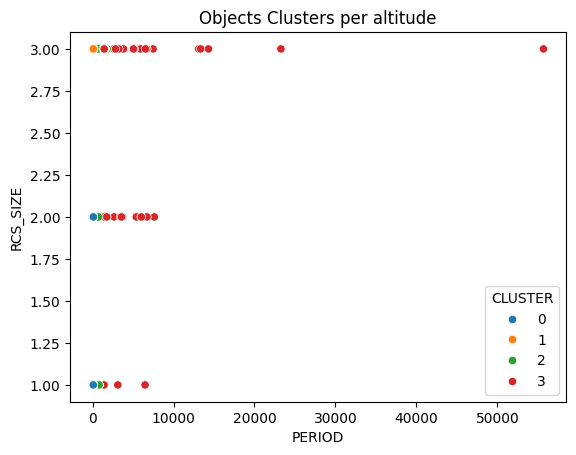

In [79]:
# Visualizing Clusters

# Visualize cluster distribution
sns.scatterplot(data = df_cluster, 
                x = 'PERIOD', 
                y = 'RCS_SIZE', 
                hue = 'CLUSTER', 
                palette = 'tab10')
plt.title('Objects Clusters per altitude')
plt.show();

**Patterns to consider:**
- Clusters with **high Apogee / Perigee values**: higher orbits.<br>
- Clusters with **high Inclination**: polar or retrograde orbits.<br>
- Clusters with **very low Period**: LEO objects.<br>
- Clusters with **high RCS_SIZE**: larger satellites, perhaps military or telecommunications.

### 8.2 - Classification DBSCAN & PCA: Orbital Collision Risk

In [334]:
# Preprocessing

# Convert RCS_SIZE for numeric values
rcs_map = {'SMALL': 1, 
           'MEDIUM': 2, 
           'LARGE': 3}

df_active['RCS_SIZE_quanti'] = df_active['RCS_SIZE'].map(rcs_map)

# Selecting relevant features
features = ['APOGEE',
            'PERIGEE',
            'INCLINATION',
            'RCS_SIZE_quanti']

df_active_reduced = df_active[features + ['ORBIT_TYPE']].dropna()

# Normalizing data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_active_reduced[features])


In [335]:
# Clustering with DBSCAN
dbscan = DBSCAN(eps = 0.5, 
                min_samples = 10)
clusters = dbscan.fit_predict(X_scaled)

# Adding clusters to dataframe
df_active_reduced['CLUSTER'] = clusters


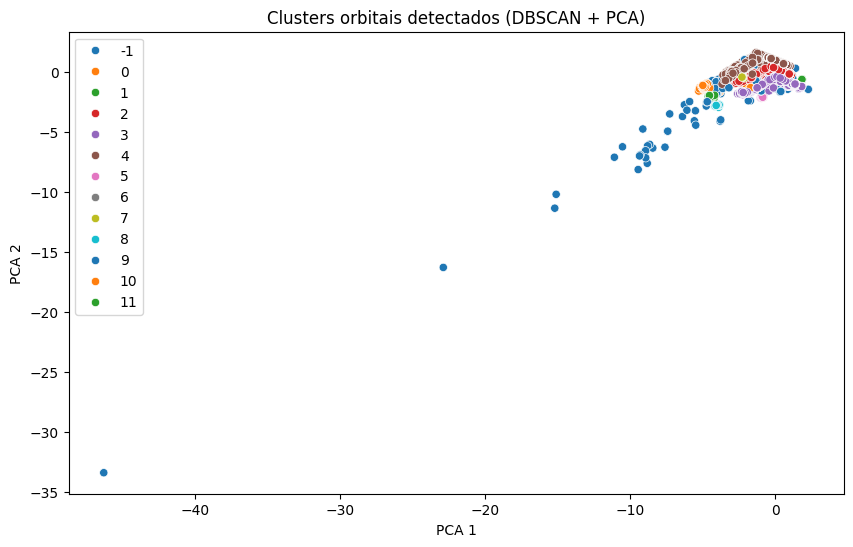

In [336]:
# Visualizing with PCA

# Reduction to 2D for visualization
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize = (10, 6))
sns.scatterplot(x = X_pca[:,0], 
                y = X_pca[:,1], 
                hue = clusters, 
                palette = 'tab10')

plt.title('Clusters orbitais detectados (DBSCAN + PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show();

In [337]:
# Risk classification

# Creating simple metric for risk
df_active_reduced['RISK'] = 'LOW'

# Regras heurísticas (você pode ajustar)
df_active_reduced.loc[(df_active_reduced['CLUSTER'] != -1) & (df_active_reduced['RCS_SIZE_quanti'] > 1.5), 'RISK'] = 'HIGH'
df_active_reduced.loc[(df_active_reduced['CLUSTER'] != -1) & (df_active_reduced['RCS_SIZE_quanti'] <= 1.5), 'RISK'] = 'MEDIUM'


In [338]:
# Objects with higher risks
df_active_reduced[df_active_reduced['RISK'] == 'HIGH'].head(10)

APOGEE  PERIGEE  INCLINATION  RCS_SIZE_quanti ORBIT_TYPE  CLUSTER  RISK
1   36113.0  35879.0        13.99              3.0        GEO        0  HIGH
2   36110.0  36052.0        14.08              3.0        GEO        0  HIGH
3   36270.0  36077.0        13.79              3.0        GEO        0  HIGH
4   35947.0  35639.0        12.17              3.0        GEO        0  HIGH
5   36053.0  36006.0         9.98              3.0        GEO        0  HIGH
6   35821.0  35814.0        11.48              3.0        GEO        0  HIGH
7   36247.0  36192.0         2.14              3.0        GEO        0  HIGH
8   35793.0  35710.0        12.67              3.0        GEO        0  HIGH
9   35804.0  35771.0         1.28              3.0        GEO        0  HIGH
10  35810.0  35763.0         0.05              3.0        GEO        0  HIGH

In [339]:
df_active_reduced['RISK'].value_counts()

RISK
HIGH      18768
MEDIUM    10823
LOW         114
Name: count, dtype: int64

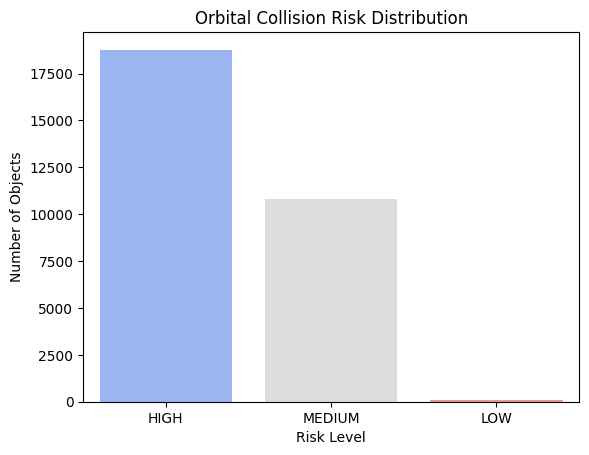

In [340]:
# Counting
RiskCount_df = df_active_reduced['RISK'].value_counts().reset_index()
RiskCount_df.columns = ['RISK', 'OBJECTS']

# Gráfico
sns.barplot(data = RiskCount_df, 
            x = 'RISK', 
            y = 'OBJECTS', 
            palette = 'coolwarm')

plt.title('Orbital Collision Risk Distribution')
plt.ylabel('Number of Objects')
plt.xlabel('Risk Level')
plt.show();

In [341]:
# Contagem de risco por tipo de órbita
risco_por_orbita = df_active_reduced.groupby(['ORBIT_TYPE', 'RISK']).size().unstack(fill_value=0)

print(risco_por_orbita)

RISK         HIGH  LOW  MEDIUM
ORBIT_TYPE                    
LEO         14870    3    9953
MEO          2351   43     843
GEO          1282    9      12
HEO           255   59      10
Unknown         0    0       0
Undefined      10    0       5


In [343]:
# Interactive visualization

df_pca = pd.DataFrame(X_pca, 
                      columns = ['PCA1', 'PCA2'])

df_pca['Cluster'] = clusters

df_pca['Risk'] = df_active_reduced['RISK'].values

fig = px.scatter(df_pca, 
                 x = 'PCA1', 
                 y = 'PCA2', 
                 color = 'Risk', 
                 symbol = 'Cluster',
                 title = 'Orbital Clusters with Risk Classification')
fig.show();

### 8.3 - Classification DBSCAN & PCA: Orbital Collision Risk - REFINED

In [345]:
# Contar quantos objetos há em cada cluster
cluster_counts = df_active_reduced['CLUSTER'].value_counts().to_dict()

# Mapear essa contagem para cada objeto
df_active_reduced['CLUSTER_DENSITY'] = df_active_reduced['CLUSTER'].map(cluster_counts)


In [346]:
# Calcular métrica de risco combinada
df_active_reduced['RISK_SCORE'] = df_active_reduced['CLUSTER_DENSITY'] * df_active_reduced['RCS_SIZE_quanti']


In [347]:
# Classificar com base no score

# Calcular os limites
low_thresh = df_active_reduced['RISK_SCORE'].quantile(0.33)
high_thresh = df_active_reduced['RISK_SCORE'].quantile(0.66)

# Classificar
df_active_reduced['RISK_LEVEL'] = 'LOW'
df_active_reduced.loc[df_active_reduced['RISK_SCORE'] > low_thresh, 'RISK_LEVEL'] = 'MEDIUM'
df_active_reduced.loc[df_active_reduced['RISK_SCORE'] > high_thresh, 'RISK_LEVEL'] = 'HIGH'


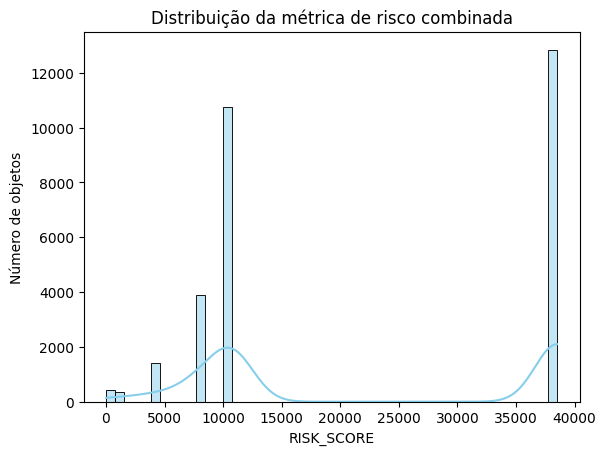

In [348]:
# Visualização

sns.histplot(df_active_reduced['RISK_SCORE'], 
             bins = 50, 
             kde = True, 
             color = 'skyblue')

plt.title('Distribuição da métrica de risco combinada')
plt.xlabel('RISK_SCORE')
plt.ylabel('Número de objetos')
plt.show();

**Interpretação**:
- Objetos com alto RCS em clusters densos terão RISK_SCORE alto.
- Objetos grandes e isolados terão score médio.
- Objetos pequenso em clusters dispersos terão score baixo.

### 8.4 - Object Decay Prediction

In [350]:
# Creating Target Variable, binary
df['DECAYED'] = df['DECAY'].notnull().astype(int)


In [351]:
# Converting RCS_SIZE to numeric values
rcs_map = {'SMALL': 1, 
           'MEDIUM': 2, 
           'LARGE': 3}
df['RCS_SIZE_quanti'] = df['RCS_SIZE'].map(rcs_map)


In [352]:
# Selecting relevant features
features = ['APOGEE', 
            'PERIGEE', 
            'INCLINATION', 
            'PERIOD', 
            'RCS_SIZE_quanti', 
            'LAUNCH_YEAR']

df_model = df[features + ['DECAYED']].dropna()


In [353]:
# Creating Train & Test

X = df_model[features]
y = df_model['DECAYED']

# Normalizing data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividing Train and Test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    random_state = 42)


In [354]:
# Training Model - Random Forest

model = RandomForestClassifier(n_estimators = 100, 
                               random_state = 42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [355]:
# Evaluation

# Prediction
y_pred = model.predict(X_test)

# Performance report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[8619  236]
 [ 302 7193]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8855
           1       0.97      0.96      0.96      7495

    accuracy                           0.97     16350
   macro avg       0.97      0.97      0.97     16350
weighted avg       0.97      0.97      0.97     16350



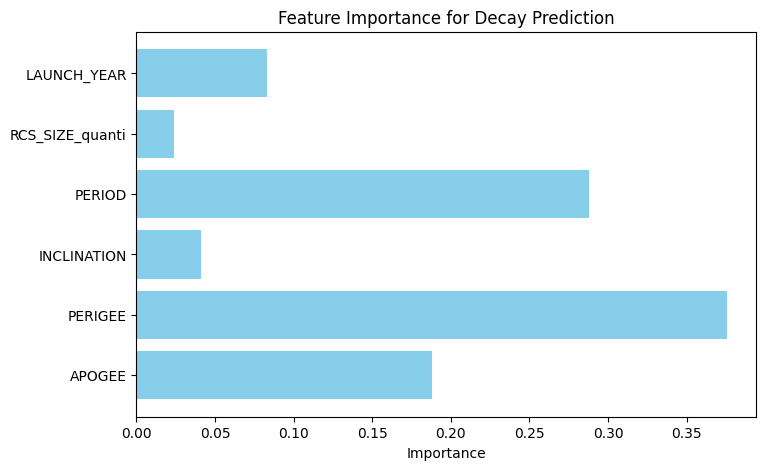

In [356]:
# Variable relevance

# Feature relevance
importances = model.feature_importances_
feature_names = features

# Visualização
plt.figure(figsize = (8, 5))
plt.barh(feature_names, 
         importances, 
         color = 'skyblue')

plt.title('Feature Importance for Decay Prediction')
plt.xlabel('Importance')
plt.show();


**Interpretation**:
- Objects with lower orbits, higher inclinations, or shorter periods tend to decay faster.
- RCS_SIZE can indicate greater atmospheric drag (depending on altitude).
- LAUNCH_YEAR helps capture time in orbit.


In [357]:
# Applying model to active objects

# Selecting only objects without DECAY date
df_active_pred = df[df['DECAY'].isnull()].copy()

# Map RCS_SIZE for numeric values
rcs_map = {'SMALL': 1, 
           'MEDIUM': 2, 
           'LARGE': 3}
df_active_pred['RCS_SIZE_quanti'] = df_active_pred['RCS_SIZE'].map(rcs_map)

# Select same features used in the model
features = ['APOGEE', 
            'PERIGEE', 
            'INCLINATION', 
            'PERIOD', 
            'RCS_SIZE_quanti', 
            'LAUNCH_YEAR']
df_active_pred_model = df_active_pred[features].dropna()


In [360]:
# normalizing data

X_active_scaled = scaler.transform(df_active_pred_model)


In [362]:
# Predictions

# Predict Decaying probability
probability = model.predict_proba(X_active_scaled)[:, 1]  # probabilidade de classe 1 (decaiu)

# Add to dataframe
df_active_pred_model['DECAY_PROBABILITY'] = probability


In [363]:
# Visualizing Objects with higher risk

# Ordenar pelos mais prováveis de decair
df_top_risk = df_active_pred_model.sort_values(by = 'DECAY_PROBABILITY', 
                                               ascending = False)

# Exibir os top 10
df_top_risk.head(10)


APOGEE  PERIGEE  INCLINATION  PERIOD  RCS_SIZE_quanti  LAUNCH_YEAR  \
37863   260.0    232.0        98.01   89.43              1.0         1999   
24264   442.0    399.0        74.01   92.98              1.0         1993   
62673   219.0    201.0        97.34   88.69              1.0         2023   
61810   215.0    206.0        53.03   88.70              3.0         2020   
37736   360.0    319.0        98.81   91.32              1.0         1999   
37723   403.0    360.0        98.91   92.18              1.0         1999   
28128   236.0    219.0        97.85   89.05              1.0         2001   
35936   200.0    185.0        98.58   88.34              2.0         1999   
25438   749.0    420.0        82.22   96.36              1.0         1982   
38037   261.0    252.0        97.52   89.64              3.0         2015   

       DECAY_PROBABILITY  
37863                1.0  
24264                1.0  
62673                1.0  
61810                1.0  
37736                1.0  
37723                1.0  
28128                1.0  
35936                1.0  
25438                1.0  
38037                1.0

In [364]:
# Classifying in Risk categories
df_active_pred_model['DECAY_RISK'] = 'LOW'
df_active_pred_model.loc[df_active_pred_model['DECAY_PROBABILITY'] > 0.33, 'DECAY_RISK'] = 'MEDIUM'
df_active_pred_model.loc[df_active_pred_model['DECAY_PROBABILITY'] > 0.66, 'DECAY_RISK'] = 'HIGH'


In [366]:
# Add context columns

# Recuperar os índices originais dos objetos ativos
df_active_pred_model = df_active_pred_model.copy()
df_active_pred_model['INDEX'] = df_active_pred_model.index

# Juntar com colunas contextuais do df_ativos
context_cols = ['SATNAME', 
                'COUNTRY', 
                'ORBIT_TYPE']
df_context = df_active_pred[context_cols].reset_index()

# Mesclar os dados
df_active_pred_model = df_active_pred_model.merge(df_context, 
                                                  left_on = 'INDEX', 
                                                  right_on = 'index', 
                                                  how = 'left')


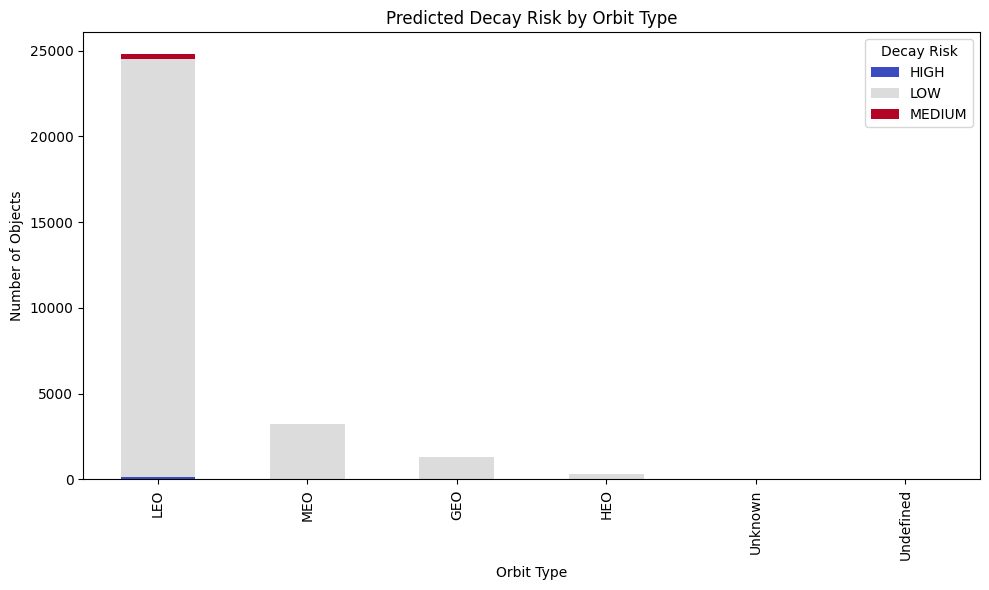

In [367]:
# Agrupar por tipo de órbita e risco
RiskPerOrbit = df_active_pred_model.groupby(['ORBIT_TYPE', 'DECAY_RISK']).size().unstack(fill_value=0)


RiskPerOrbit.plot(kind = 'bar', 
                  stacked = True, 
                  colormap = 'coolwarm', 
                  figsize = (10, 6))
plt.title('Predicted Decay Risk by Orbit Type')
plt.ylabel('Number of Objects')
plt.xlabel('Orbit Type')
plt.legend(title='Decay Risk')
plt.tight_layout()
plt.show();


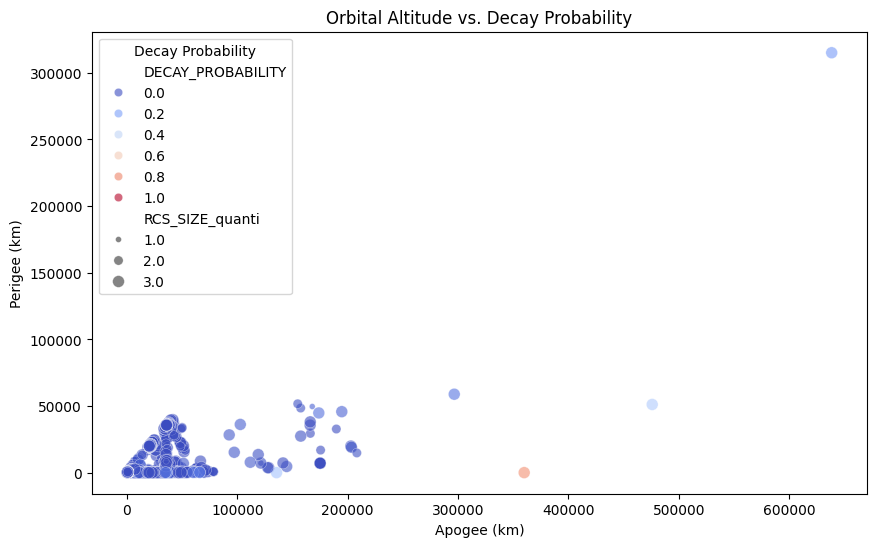

In [369]:
plt.figure(figsize = (10,6))

sns.scatterplot(data = df_active_pred_model, 
                x = 'APOGEE', 
                y = 'PERIGEE', 
                hue = 'DECAY_PROBABILITY', 
                palette = 'coolwarm', 
                size = 'RCS_SIZE_quanti', 
                alpha = 0.6)

plt.title('Orbital Altitude vs. Decay Probability')
plt.xlabel('Apogee (km)')
plt.ylabel('Perigee (km)')
plt.legend(title='Decay Probability')

plt.show();

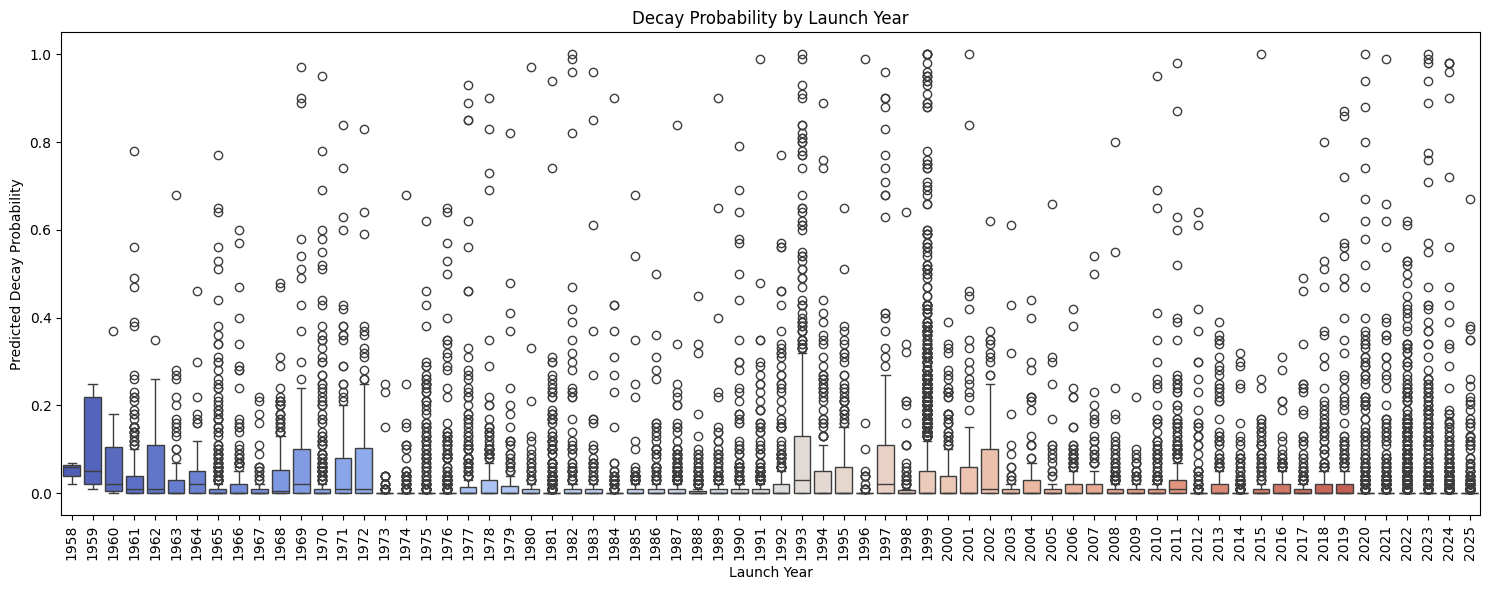

In [371]:
plt.figure(figsize = (15,6))

sns.boxplot(data = df_active_pred_model, 
            x = 'LAUNCH_YEAR', 
            y = 'DECAY_PROBABILITY', 
            palette = 'coolwarm')

plt.xticks(rotation = 90)
plt.title('Decay Probability by Launch Year')
plt.ylabel('Predicted Decay Probability')
plt.xlabel('Launch Year')
plt.tight_layout()

plt.show(); 

In [372]:
# Contagem de risco por tipo de órbita
DecayPerOrbit = df_active_pred_model.groupby(['ORBIT_TYPE', 'DECAY_PROBABILITY']).size().unstack(fill_value=0)

DecayPerOrbit

DECAY_PROBABILITY  0.000000  0.010000  0.014000  0.020000  0.025000  0.030000  \
ORBIT_TYPE                                                                      
LEO                   18164      1619         1       820         1       515   
MEO                    2215       380         0       190         0       113   
GEO                    1286         9         0         3         0         1   
HEO                     283        16         0         6         0         6   
Unknown                   0         0         0         0         0         0   
Undefined                 6         0         0         0         0         0   

DECAY_PROBABILITY  0.040000  0.050000  0.060000  0.066667  0.070000  0.080000  \
ORBIT_TYPE                                                                      
LEO                     398       334       272         1       241       196   
MEO                      80        50        29         0        32        12   
GEO                       2         0         0         0         0         0   
HEO                       1         3         0         0         1         1   
Unknown                   0         0         0         0         0         0   
Undefined                 0         0         0         0         0         0   

DECAY_PROBABILITY  0.090000  0.100000  0.110000  0.118333  0.120000  0.129167  \
ORBIT_TYPE                                                                      
LEO                     159       148       134         1       132         1   
MEO                      20        14        11         0        11         0   
GEO                       0         0         0         0         1         0   
HEO                       2         0         0         0         1         0   
Unknown                   0         0         0         0         0         0   
Undefined                 0         0         0         0         0         0   

DECAY_PROBABILITY  0.130000  0.140000  0.150000  0.160000  0.165000  0.170000  \
ORBIT_TYPE                                                                      
LEO                     110        90       108        91         1        85   
MEO                      10         8         7         5         0         4   
GEO                       0         0         0         0         0         0   
HEO                       0         0         0         0         0         0   
Unknown                   0         0         0         0         0         0   
Undefined                 0         0         0         0         0         0   

DECAY_PROBABILITY  0.180000  0.190000  0.200000  0.204000  0.210000  0.220000  \
ORBIT_TYPE                                                                      
LEO                      77        55        59         1        56        69   
MEO                       1         1         3         0         0         6   
GEO                       0         0         0         0         0         0   
HEO                       0         1         0         0         0         0   
Unknown                   0         0         0         0         0         0   
Undefined                 0         0         0         0         0         0   

DECAY_PROBABILITY  0.230000  0.240000  0.244333  0.250000  0.260000  0.270000  \
ORBIT_TYPE                                                                      
LEO                      56        54         1        60        50        37   
MEO                       3         2         0         1         2         5   
GEO                       0         0         0         0         0         0   
HEO                       0         0         0         0         0         0   
Unknown                   0         0         0         0         0         0   
Undefined                 0         0         0         0         0         0   

DECAY_PROBABILITY  0.280000  0.290000  0.300000  0.310000  0.320000  0.322500  \
ORBIT_TYPE               

`DECAY_PROBABILITY`
Variable generated during the prediction model, representing the estimated probability of a object decay.

Values range:<br>
0.0 - model understands that the object has minimal decay chance (very stable in its orbit).<br>
1.0 - model understands that the object has maximal decay chance (it is highly probably that it reenters Earth atmosphere).<br>
intermediate values - gradual levels of risk, based on orbital and physical characteristics.

In [374]:
df_active_pred_model.columns

Index(['APOGEE', 'PERIGEE', 'INCLINATION', 'PERIOD', 'RCS_SIZE_quanti',
       'LAUNCH_YEAR', 'DECAY_PROBABILITY', 'DECAY_RISK', 'INDEX', 'index',
       'SATNAME', 'COUNTRY', 'ORBIT_TYPE'],
      dtype='object')

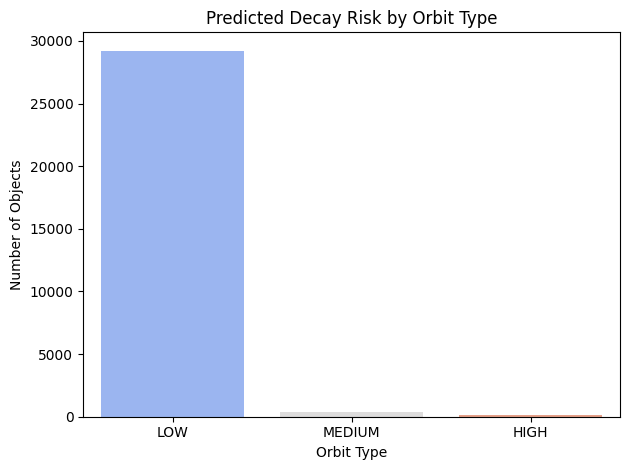

In [375]:
# Counting
DecayRisk_df = df_active_pred_model['DECAY_RISK'].value_counts().reset_index()
DecayRisk_df.columns = ['DECAY_RISK', 'OBJECTS']

# Gráfico
sns.barplot(data = DecayRisk_df, 
            x = 'DECAY_RISK', 
            y = 'OBJECTS', 
            palette = 'coolwarm')

plt.title('Predicted Decay Risk by Orbit Type')
plt.ylabel('Number of Objects')
plt.xlabel('Orbit Type')
plt.tight_layout()
plt.show();

In [376]:
# Contagem de risco por tipo de órbita
DecayRiskPerOrbit = df_active_pred_model.groupby(['ORBIT_TYPE', 'DECAY_RISK']).size().unstack(fill_value=0)

DecayRiskPerOrbit

DECAY_RISK  HIGH    LOW  MEDIUM
ORBIT_TYPE                     
LEO          119  24380     327
MEO            8   3217      12
GEO            0   1302       1
HEO            1    322       1
Unknown        0      0       0
Undefined      3      7       5

---

## 9 - Animated Chart - Launchs per Country timeline

In [29]:
# Chart Style
style.use('seaborn-v0_8')

In [30]:
# Count: Launchs per year 
launch_counts = df['LAUNCH_YEAR'].value_counts().sort_index()

# Count: Decays per year (ignore NaN)
decay_counts = df['DECAY_YEAR'].dropna().astype(int).value_counts().sort_index()

In [31]:
# Creating a combined dataframe for plotting
years = sorted(set(launch_counts.index).union(set(decay_counts.index)))
launch_series = launch_counts.reindex(years, 
                                      fill_value = 0)
decay_series = decay_counts.reindex(years, 
                                    fill_value = 0)

In [55]:
%%script true
# Plotting
plt.figure(figsize = (10, 6))

plt.plot(years, 
         launch_series, 
         label = 'Launch', 
         color = 'navy', 
         linestyle = '-')

plt.plot(years, 
         decay_series, 
         label = 'Decay', 
         color = 'skyblue', 
         linestyle = '--')

plt.xlabel('Year')
plt.ylabel('Objects count')
plt.title('Objects Launch and Decay per year')

plt.legend()
plt.grid(True)

plt.show();


In [34]:
# Accumulated count of Launch per year
launch_counts = df['LAUNCH_YEAR'].value_counts().sort_index()
launch_cumulative = launch_counts.cumsum()

# Accumulated count of Decay per year (ignore NaN)
decay_counts = df['DECAY_YEAR'].dropna().astype(int).value_counts().sort_index()
decay_cumulative = decay_counts.cumsum()

In [35]:
# Creating a range of years 
all_years = sorted(set(df['LAUNCH_YEAR']).union(set(df['DECAY_YEAR'].dropna().astype(int))))

# Reindexing to guarantee all years are present
launch_cumulative = launch_cumulative.reindex(all_years, 
                                              fill_value = 0).ffill()
decay_cumulative = decay_cumulative.reindex(all_years, 
                                            fill_value = 0).ffill()


In [56]:
%%script true
# Plotting
fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(all_years, 
         launch_cumulative, 
         label = 'Accumulated Launches', 
         color = 'darkblue', 
         linestyle = '-')

plt.plot(all_years, 
         decay_cumulative, 
         label = 'Accumulated Decays', 
         color = 'lightblue', 
         linestyle = '--')

fig.patch.set_facecolor('white')       
ax.set_facecolor('white') 

#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.grid(False)

plt.xlabel('Year')
plt.ylabel('Accumulated Number of Objects')
plt.title('Objects in orbit: Accumulated Launches and Decays')

plt.legend()
plt.grid(True)

plt.show();

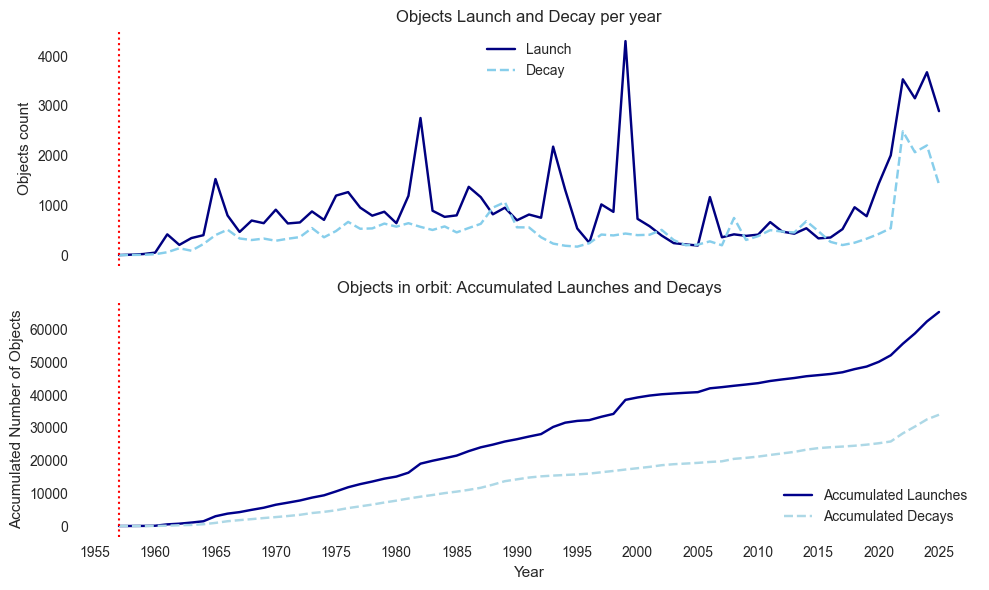

In [54]:
# Plotting

fig, axes = plt.subplots(nrows = 2, 
                         ncols = 1, 
                         sharex = True, 
                         figsize = (10, 6))


# First Chart ------- Objects Launch and Decay per year
axes[0].plot(
         years, 
         launch_series, 
         label = 'Launch', 
         color = 'navy', 
         linestyle = '-')
axes[0].plot(
         years, 
         decay_series, 
         label = 'Decay', 
         color = 'skyblue', 
         linestyle = '--')
axes[0].patch.set_facecolor('white')       
axes[0].set_facecolor('white') 
axes[0].set_ylabel('Objects count')
axes[0].set_title('Objects Launch and Decay per year')
axes[0].legend()

# Second Chart ------- Objects Launch and Decay per year
axes[1].plot(
         all_years, 
         launch_cumulative, 
         label = 'Accumulated Launches', 
         color = 'darkblue', 
         linestyle = '-')
axes[1].plot(
         all_years, 
         decay_cumulative, 
         label = 'Accumulated Decays', 
         color = 'lightblue', 
         linestyle = '--')
axes[1].patch.set_facecolor('white')       
axes[1].set_facecolor('white') 
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Accumulated Number of Objects')
axes[1].set_title('Objects in orbit: Accumulated Launches and Decays')
axes[1].legend()

axes[1].xaxis.set_major_locator(ticker.MultipleLocator(5))

# Vertical Line in 1957
axes[0].axvline(x = 1957, 
                color = 'red', 
                linestyle = ':', 
                linewidth = 1.5)
axes[1].axvline(x = 1957, 
                color = 'red', 
                linestyle = ':', 
                linewidth = 1.5)

plt.tight_layout()
plt.show();

---